In [1]:
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from parflow import Run, read_pfb, write_pfb, ParflowBinaryReader,read_pfb_sequence

In [3]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/"
wdir = root_dir+'results/'

In [4]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(os.sep.join([root_dir,'forc_bani_5min_2006_2009.txt']),header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2006 00:00:00', periods=len(forc), freq='5min')
P=forc['P']*5*60
forc

SWin      LWin    P         T   WindX  WindY    Press  \
2006-01-01 00:00:00  3.7305  316.1700  0.0  291.1000  0.9565    0.0  98450.0   
2006-01-01 00:05:00  3.7260  316.3100  0.0  291.0508  0.9113    0.0  98450.0   
2006-01-01 00:10:00  3.7215  316.4500  0.0  291.0017  0.8660    0.0  98450.0   
2006-01-01 00:15:00  3.7170  316.5900  0.0  290.9525  0.8208    0.0  98450.0   
2006-01-01 00:20:00  3.7125  316.7300  0.0  290.9033  0.7755    0.0  98450.0   
...                     ...       ...  ...       ...     ...    ...      ...   
2009-12-31 23:10:00 -0.2190  318.3567  0.0  292.3033  0.2318    0.0  98750.0   
2009-12-31 23:15:00 -0.2070  318.2350  0.0  292.1475  0.1910    0.0  98750.0   
2009-12-31 23:20:00 -0.1950  318.1133  0.0  291.9917  0.1502    0.0  98750.0   
2009-12-31 23:25:00 -0.1830  317.9917  0.0  291.8358  0.1093    0.0  98750.0   
2009-12-31 23:30:00 -0.1710  317.8700  0.0  291.6800  0.0685    0.0  98750.0   

                         Hs  
2006-01-01 00:00:00  0.0026  
2006-01-01 00:05:00  0.0026  
2006-01-01 00:10:00  0.0026  
2006-01-01 00:15:00  0.0026  
2006-01-01 00:20:00  0.0026  
...                     ...  
2009-12-31 23:10:00  0.0022  
2009-12-31 23:15:00  0.0022  
2009-12-31 23:20:00  0.0022  
2009-12-31 23:25:00  0.0022  
2009-12-31 23:30:00  0.0022  

[420763 rows x 8 columns]

In [5]:
data_evts_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/evts_banizoumbou_6h_90_21.txt"
data_evts = pd.read_csv(data_evts_file,sep='\t')

In [6]:
data_evts.Starting = data_evts.Starting.apply(lambda x: pd.to_datetime(x))
data_evts.End = data_evts.End.apply(lambda x: pd.to_datetime(x))

In [7]:
subset = data_evts.loc[(data_evts.Volume>15) & (data_evts.Volume<20) & \
              (data_evts.Starting.dt.year>2006) & (data_evts.Starting.dt.year<2009) &\
              (data_evts.Duration>2.5) & (data_evts.Duration<4.5),:]
subset

Starting                 End  Duration  Volume  Intensity
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500

In [8]:
# avec:
#pevent = P.loc[(P.index>= subset.Starting.iloc[0]+pd.Timedelta(minutes=10)) & \
#      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]

#=> Jusqu'à 50% d'erreur de bilan avec un pdt de 25 ou 30mn. Sans doute pb de post processing

pevent = P.loc[(P.index>= subset.Starting.iloc[0]-pd.Timedelta(minutes=20)) & \
      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]

In [9]:
pevent

2007-07-23 11:10:00    0.00
2007-07-23 11:15:00    0.00
2007-07-23 11:20:00    0.00
2007-07-23 11:25:00    0.00
2007-07-23 11:30:00    0.00
2007-07-23 11:35:00    0.00
2007-07-23 11:40:00    0.00
2007-07-23 11:45:00    2.28
2007-07-23 11:50:00    6.06
2007-07-23 11:55:00    4.08
2007-07-23 12:00:00    0.66
2007-07-23 12:05:00    0.75
2007-07-23 12:10:00    0.87
2007-07-23 12:15:00    0.42
2007-07-23 12:20:00    0.27
2007-07-23 12:25:00    0.24
2007-07-23 12:30:00    0.18
2007-07-23 12:35:00    0.18
2007-07-23 12:40:00    0.18
2007-07-23 12:45:00    0.18
2007-07-23 12:50:00    0.18
2007-07-23 12:55:00    0.21
2007-07-23 13:00:00    0.21
2007-07-23 13:05:00    0.24
2007-07-23 13:10:00    0.24
2007-07-23 13:15:00    0.18
2007-07-23 13:20:00    0.15
2007-07-23 13:25:00    0.15
2007-07-23 13:30:00    0.12
2007-07-23 13:35:00    0.12
2007-07-23 13:40:00    0.12
2007-07-23 13:45:00    0.12
2007-07-23 13:50:00    0.12
2007-07-23 13:55:00    0.15
2007-07-23 14:00:00    0.15
2007-07-23 14:05:00 

In [10]:
vol = pevent.sum()
print(vol)

19.409999999999997


## Some Functions

In [11]:
def load_convert_and_run_simulation(simuname,tstep,ntstep,forcing_event,root_dir,manning):
    sim = Run.from_definition(simuname)
    sim.TimingInfo.StopTime = ntstep*tstep
    sim.Cycle.rain.Names = ' '.join('_%d'%i for i in range(ntstep))
    for i in range(ntstep):
        sim.Cycle.rain['_%d'%i].Length = tstep
    sim.Patch.z_upper.BCPressure.Cycle = 'rain'
    sim.TimeStep.Value = tstep
    sim.TimingInfo.DumpInterval = tstep
    
    #how much the relative reduction in the nonlinear residual should
    #be before nonlinear iterations stop. 
    #The magnitude of the residual is measured with the l 1 (max) norm.
    sim.Solver.Nonlinear.ResidualTol = 1e-13
    
    #This value gives the absolute tolerance for the linear solve algorithm.
    sim.Solver.AbsTol = 1e-8
    
    #This key specifies how the linear system tolerance will be selected. The linear system is solved until a relative
#residual reduction of η is achieved. Linear residuall norms are measured in the l 2 norm. Choices for this key include
#EtaConstant, Walker1 and Walker2. If the choice EtaConstant is specified, then η will be taken as constant.
#The choices Walker1 and Walker2 specify choices for η developed by Eisenstat and Walker [32]. The choice
#Walker1 specifies that η will be given by |kF (u k )k − kF (u k−1 ) + J(u k−1 ) ∗ pk|/kF (u k−1 )k. The choice Walker2
#specifies that η will be given by γkF (u k )k/kF (u k−1 )k α . For both of the last two choices, η is never allowed to be less
#than 1e-4.
    sim.Solver.Nonlinear.EtaChoice = "Walker2"
    sim.Solver.Nonlinear.EtaAlpha = 0.0001
    sim.Solver.Nonlinear.EtaGamma = 0.0001

    
    #sim.Solver.Nonlinear.EtaValue = 1e-7
    
    
    sim.Solver.Nonlinear.MaxIter = 50
    #the tolerance that measures how small the difference between two consecutive nonlinear steps
    #can be before nonlinear iterations stop
    # when reached, it crashes
    #sim.Solver.Nonlinear.StepTol = 1e-10

    for i in range(ntstep):
        sim.Patch.z_upper.BCPressure['_%d'%i].Value = -forcing_event.iloc[i]/1000    
    sim.Mannings.Geom.domain.Value = manning     
    wdir = root_dir+'results/'
    if os.path.exists(wdir):
        shutil.rmtree(wdir)
    os.mkdir(wdir)        
    
    shutil.copy(root_dir+'slopey.pfb',wdir+'slopey.pfb')
    shutil.copy(root_dir+'perm1s.pfb',wdir+'perm1s.pfb')
    #hill.ComputationalGrid.NZ = 1
    sim.dist(wdir+'slopey.pfb')
    #hill.ComputationalGrid.NZ = 30
    sim.dist(wdir+'perm1s.pfb')
    sim.run(working_directory=wdir,skip_validation=False)

In [12]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01",freq='h'):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq=freq),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(storage_mm=lambda x: x.storage*1000/h['dx']/h['dy']/h['ny'])
    
    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.storage_mm.attrs['units']='mm'    
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [13]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [14]:
def read_outputs(wdir,date_start,freq,manning):
    ds1 = copy.deepcopy(read_and_process_pf_outputs(wdir,date_start=date_start,freq=freq))
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    h['dx']
    ds1 = ds1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds1 = ds1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
    ds1 = ds1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))
    ds1 = ds1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.press.data[:,0,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         h['dx'],h['dy'],manning)))
    ds1.Q.attrs['units']='m3/s'
    ds1 = ds1.assign(Qmm = lambda x: x.Q/h['dx']/h['nx']/h['dy']/h['ny']*1000)
    return ds1

In [15]:
freq_str='1s'
if 's' in freq_str:
    print('ok')

ok


In [16]:
if freq_str in ['10s']:
    print('ok')

In [17]:
int(freq_str.split('s')[0])

1

In [18]:
def create_forcing_ts(base_forcing,freq_str,original_tstep_second,tstep):

    #check tstep and freq_str are coherent:
    if 's' in freq_str:
        tstep_from_freq = int(freq_str.split('s')[0])
    elif 'min' in freq_str:
        tstep_from_freq = int(freq_str.split('min')[0])
    if tstep_from_freq != tstep:
        print('error in tstep vs. freq_str, should match')
    #Interpolate forcing at freq_str and switch from mm/5mn to mm/freq_unit
    # or, if freq_str is at lower resolution than original_tstep_second, aggregate cumulative values
    
    if 's' in freq_str:
        new_forcing = base_forcing.resample(freq_str).interpolate('linear')/original_tstep_second
        # this divides by 60 x 5 seconds
        
    elif 'min' in freq_str:
    
        if tstep_from_freq<=original_tstep_second/60.:
            new_forcing = base_forcing.resample(freq_str).interpolate('linear')/original_tstep_second*60.
            # this divides by 5 minutes

        else:
            new_forcing = base_forcing.resample(freq_str).sum()/tstep
    
    else: 
        print('error freq_str can only be s or min')
    return new_forcing    

In [19]:
def run_and_analyse_single_simulation(base_forcing,freq_str,original_tstep_second,tstep,root_dir,simname,base_manning = 0.0000056):

    new_forcing = create_forcing_ts(base_forcing,freq_str,original_tstep_second,tstep)

    ntstep = new_forcing.size
    
    
    ## Update Ks in s or min, as well as manning:
    
    with ParflowBinaryReader(root_dir+'perm1.pfb') as pfb:
        data = pfb.read_all_subgrids()
        hdr = pfb.read_header()
        
    if 's' in freq_str:
        data = data/3600
        data[-11:-5,:,:] = 0.01/3600
        #manning = base_manning/3600.
        #corrected on the 6th may 2024:
        manning = base_manning*3600.
    elif 'min' in freq_str:
        data = data/60
        data[-11:-5,:,:] = 0.01/60
        #manning = base_manning/60.     
        #corrected on the 6th may 2024:
        manning = base_manning*60.     
    write_pfb(root_dir+'perm1s.pfb',data,**hdr)
    
    ## run parflow
    load_convert_and_run_simulation(simname,tstep,ntstep,new_forcing,root_dir,manning)
    ds = read_outputs(wdir,date_start= new_forcing.index[0],freq=freq_str,manning = manning)    

    
    vol = new_forcing.sum()*tstep
    
    # Q
    Qtot = (ds.Qmm*tstep).sum().data
    # Budg
    storage = ds.storage_mm.sum(dim='y').to_dataframe()['storage_mm']
    storage = storage - storage[0]
    budg_res = vol-storage[-1]-Qtot   
    Ke = 100*Qtot/vol
    print("freq = %s, Ke = %2.2f %%"%(freq_str,Ke))
    return [pd.DataFrame(data = {'total_precip (mm)':[vol],
                                'Le (mm)': [Qtot], 'Ke (%)': [Ke],
                               'budg (mm)':[budg_res],
                                'budg (%)':[100*budg_res/vol]}, index=[freq_str]),
            (ds.Qmm.to_dataframe()['Qmm']*tstep)]

In [20]:
simname = root_dir+'SA_mil_1.pfidb'

In [21]:
results=pd.DataFrame()
Q = dict()
list_t_resolution = {'10s':10,'30s':30,'60s':60,'1min':1,'2min':2,'5min':5,
                     '8min':8,'10min':10,'12min':12,'15min':15,'18min':18,
                     '20min':20,'25min':25,'30min':30}
#list_t_resolution = {'2min':2,'5min':5,
#                     '8min':8,'10min':10,'12min':12,'15min':15,'18min':18,
#                     '20min':20,'25min':25,'30min':30}
for key,val in list_t_resolution.items():
    [r,q] = run_and_analyse_single_simulation(pevent,key,60*5,val,root_dir,simname)
    results = pd.concat([results,r])    
    Q[key] = q    



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 10s, Ke = 2.95 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 2.97 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 60s, Ke = 3.02 %


/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.02 %


/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 2min, Ke = 2.93 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.84 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 8min, Ke = 2.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 10min, Ke = 4.23 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 12min, Ke = 3.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 15min, Ke = 3.74 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 18min, Ke = 2.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 20min, Ke = 2.22 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 25min, Ke = 1.43 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================




/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 30min, Ke = 0.00 %


/tmp/ipykernel_17179/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


In [22]:
results

total_precip (mm)             Le (mm)    Ke (%)     budg (mm)  \
10s                19.41  0.5717638190987611  2.945718 -4.956036e-13   
30s                19.41  0.5762239043581316  2.968696 -8.659740e-14   
60s                19.41  0.5866064779774719  3.022187 -7.241985e-13   
1min               19.41  0.5866064779774716  3.022187 -7.274181e-13   
2min               19.62  0.5745275570630095  2.928275 -3.648193e-13   
5min               19.41  0.7448857914039495  3.837639  3.508305e-13   
8min               19.41  0.5465718244390143  2.815929 -2.569056e-13   
10min              19.41  0.8203192387643412  4.226271 -5.400125e-13   
12min              19.41  0.7240238525072736  3.730159  2.121636e-13   
15min              19.41  0.7264516011658675  3.742667  7.236434e-13   
18min              19.41  0.5530400254473917  2.849253 -7.147616e-13   
20min              19.41  0.4318443609728587  2.224855 -9.078294e-13   
25min              19.41  0.2777722295953834  1.431078 -2.114975e-13   
30min              19.41                 0.0  0.000000 -7.638334e-13   

           budg (%)  
10s   -2.553341e-12  
30s   -4.461484e-13  
60s   -3.731059e-12  
1min  -3.747646e-12  
2min  -1.859426e-12  
5min   1.807473e-12  
8min  -1.323573e-12  
10min -2.782135e-12  
12min  1.093063e-12  
15min  3.728199e-12  
18min -3.682440e-12  
20min -4.677122e-12  
25min -1.089632e-12  
30min -3.935257e-12

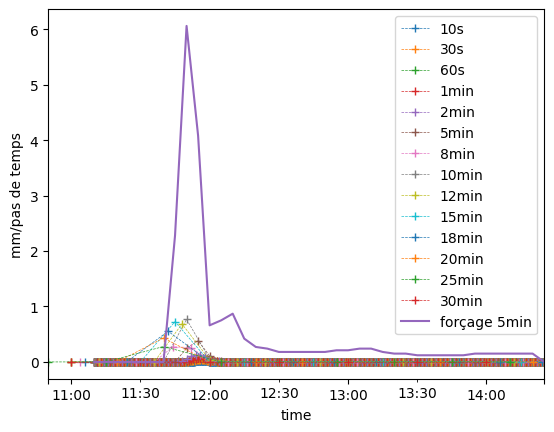

In [23]:
for key,val in Q.items():
    val.plot(label=key,style='+--',lw=0.5)
    plt.gca().set_ylabel('mm/pas de temps')
    
pevent.plot(label='forçage 5min')
plt.legend()
#plt.savefig(root_dir+'sens_res_t_timeseries.png')
# after manning correction 6/05/24
plt.savefig(root_dir+'sens_res_t_timeseries_manncorr.png')

In [24]:
def return_seconds(freq_str):
    if 's' in freq_str:
        tstep = float(freq_str.split('s')[0])
    elif 'min' in freq_str:
        tstep = float(freq_str.split('min')[0])*60
    return tstep


In [25]:
results['tstep'] = [return_seconds(x) for x in results.index]
results

total_precip (mm)             Le (mm)    Ke (%)     budg (mm)  \
10s                19.41  0.5717638190987611  2.945718 -4.956036e-13   
30s                19.41  0.5762239043581316  2.968696 -8.659740e-14   
60s                19.41  0.5866064779774719  3.022187 -7.241985e-13   
1min               19.41  0.5866064779774716  3.022187 -7.274181e-13   
2min               19.62  0.5745275570630095  2.928275 -3.648193e-13   
5min               19.41  0.7448857914039495  3.837639  3.508305e-13   
8min               19.41  0.5465718244390143  2.815929 -2.569056e-13   
10min              19.41  0.8203192387643412  4.226271 -5.400125e-13   
12min              19.41  0.7240238525072736  3.730159  2.121636e-13   
15min              19.41  0.7264516011658675  3.742667  7.236434e-13   
18min              19.41  0.5530400254473917  2.849253 -7.147616e-13   
20min              19.41  0.4318443609728587  2.224855 -9.078294e-13   
25min              19.41  0.2777722295953834  1.431078 -2.114975e-13   
30min              19.41                 0.0  0.000000 -7.638334e-13   

           budg (%)   tstep  
10s   -2.553341e-12    10.0  
30s   -4.461484e-13    30.0  
60s   -3.731059e-12    60.0  
1min  -3.747646e-12    60.0  
2min  -1.859426e-12   120.0  
5min   1.807473e-12   300.0  
8min  -1.323573e-12   480.0  
10min -2.782135e-12   600.0  
12min  1.093063e-12   720.0  
15min  3.728199e-12   900.0  
18min -3.682440e-12  1080.0  
20min -4.677122e-12  1200.0  
25min -1.089632e-12  1500.0  
30min -3.935257e-12  1800.0

In [26]:
import dataframe_image as dfi
#from dataframe_image import export_png
#dfi.export(results, root_dir+'sens_res_t_results.png')
#results.dfi.export_png(root_dir+'sens_res_t_results.png')
#results.dfi.export??
#results.dfi.export(root_dir+'/sens_res_t_results.png',table_conversion='matplotlib')
# after manning correction 6/05/24
results.dfi.export(root_dir+'/sens_res_t_results_manncorr.png',table_conversion='matplotlib')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

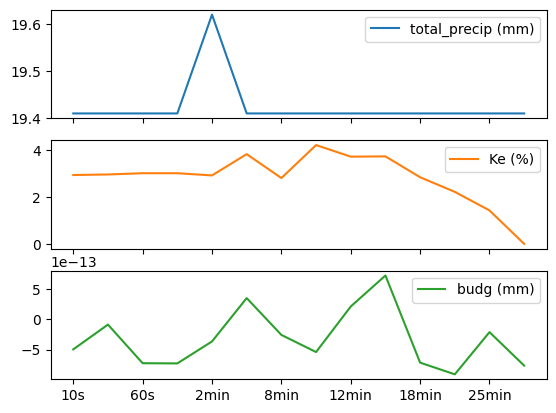

In [27]:
results.iloc[:,[0,2,3]].plot(subplots=True)

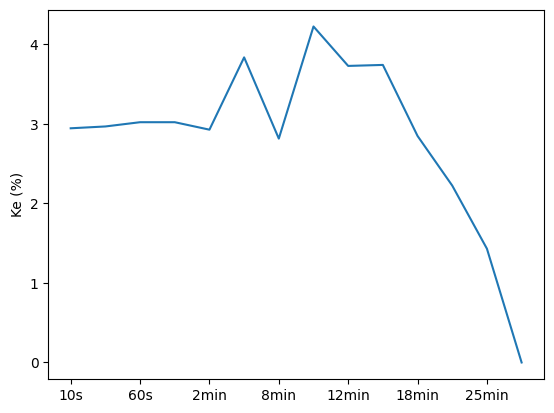

In [28]:
results.iloc[:,2].plot()
plt.gca().set_ylabel('Ke (%)')
plt.savefig(root_dir+'sens_res_t.png')
# after manning correction 6/05/24
plt.savefig(root_dir+'sens_res_t_manncorr.png')

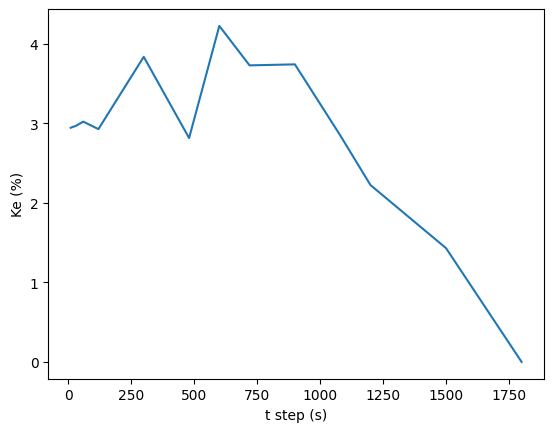

In [29]:
results2  = results.set_index('tstep')
results2.iloc[:,2].plot()
plt.gca().set_ylabel('Ke (%)')
plt.gca().set_xlabel('t step (s)')

#plt.savefig(root_dir+'sens_res_t_linear.png')
# after manning correction 6/05/24
plt.savefig(root_dir+'sens_res_t_linear_manncorr.png')


In [30]:
results2.iloc[:,[0,2,3]].plot(subplots=True)

array([<AxesSubplot:xlabel='tstep'>, <AxesSubplot:xlabel='tstep'>,
       <AxesSubplot:xlabel='tstep'>], dtype=object)

In [31]:
F = dict()
#ist_t_resolution = {'10s':10,'30s':30,'60s':60,'1min':1,'2min':2,'5min':5,
#                    '8min':8,'10min':10,'12min':12,'15min':15,'18min':18,
#                    '20min':20,'25min':25,'30min':30}
list_t_resolution = {'2min':2,'5min':5,
                     '8min':8,'10min':10,'12min':12,'15min':15}


for key,val in list_t_resolution.items():
    fo = create_forcing_ts(pevent,key,60*5,val)
    if 's' in key:
        fo = fo*60
    F[key] = fo    


    

In [32]:
for key,val in F.items():
    val.plot(label=key,style='+--',lw=0.5)
    plt.gca().set_ylabel('mm/min')
    
plt.legend()
#plt.savefig(root_dir+'sens_res_t_timeseries_forc.png')
# after manning correction 6/05/24
plt.savefig(root_dir+'sens_res_t_timeseries_forc_manncorr.png')